In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import (
    confusion_matrix, classification_report,
    f1_score, roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\viczh\anaconda3\envs\ML_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------
# 1. Load CSVs
# ---------------------------------------------------
path = "C:/Users/viczh/elliptic-data-set/elliptic_bitcoin_dataset/"

features_df = pd.read_csv(path + "elliptic_txs_features.csv", header=None)
classes_df  = pd.read_csv(path + "elliptic_txs_classes.csv")
edges_df    = pd.read_csv(path + "elliptic_txs_edgelist.csv")

colnames = ["txId", "timestep"] + [f"f_{i}" for i in range(165)]
features_df.columns = colnames

# Merge class info
features_df = features_df.merge(classes_df, on="txId", how="left")

# Map class
classes_df = classes_df[classes_df["class"] != "unknown"]
classes_df["class"] = classes_df["class"].map({'1': 1, '2': 0})

# ---------------------------------------------------
# Create feature matrix
# ---------------------------------------------------
tx_id = features_df["txId"].values
txid_to_idx = {tid: i for i, tid in enumerate(tx_id)}

X = features_df.iloc[:, 2:167].values
x = torch.tensor(X, dtype=torch.float)

timestep = torch.tensor(features_df["timestep"].values, dtype=torch.long)

# ---------------------------------------------------
# Create label vector (unknown = -1)
# ---------------------------------------------------
y = torch.full((len(tx_id),), -1, dtype=torch.long)
for _, row in classes_df.iterrows():
    y[txid_to_idx[row.txId]] = row["class"]

# ---------------------------------------------------
# Edges
# ---------------------------------------------------
src, dst = [], []
for _, row in edges_df.iterrows():
    if row.txId1 in txid_to_idx and row.txId2 in txid_to_idx:
        src.append(txid_to_idx[row.txId1])
        dst.append(txid_to_idx[row.txId2])

edge_index = torch.tensor([src, dst], dtype=torch.long)

# ---------------------------------------------------
# PyG Data object
# ---------------------------------------------------
data = Data(
    x=x,
    y=y,
    timestep=timestep,
    edge_index=edge_index
)

# Time-based masks
data.train_mask = (data.timestep < 35)
data.val_mask   = (data.timestep >= 35) & (data.timestep < 42)
data.test_mask  = (data.timestep >= 42)

labeled_mask = data.y != -1

# ---------------------------------------------------
# GraphSAGE with Dropout + BatchNorm
# ---------------------------------------------------
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        return self.classifier(x)

model = GraphSAGE(
    in_channels=data.x.size(1),
    hidden_channels=64,
    out_channels=2
).to(device)

# Weighted loss
pos_weight = (data.y == 0).sum() / (data.y == 1).sum()
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1., pos_weight]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ---------------------------------------------------
# Node Mini-Batching Loader (Windows-safe)
# ---------------------------------------------------
batch_size = 4096

train_indices = torch.where(data.train_mask & labeled_mask)[0]
train_loader  = DataLoader(train_indices, batch_size=batch_size, shuffle=True)


In [13]:

# ---------------------------------------------------
# Training Loop (Mini-Batch per-node)
# ---------------------------------------------------
best_val_f1 = -1.0
patience = 5
no_improve = 0
best_state = None

for epoch in range(1, 51):
    model.train()
    total_loss = 0.0

    for batch_nodes in train_loader:
        optimizer.zero_grad()
        logits = model(data.x.to(device), data.edge_index.to(device))
        loss = criterion(logits[batch_nodes], data.y[batch_nodes].to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # ---- validation ----
    model.eval()
    with torch.no_grad():
        val_mask = (data.val_mask & (data.y != -1))
        val_logits = model(data.x.to(device), data.edge_index.to(device))[val_mask]
        val_true = data.y[val_mask].cpu().numpy()
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        val_preds = (val_probs >= 0.5).astype(int)  # or some fixed threshold for selection

    val_f1_illicit = f1_score(val_true, val_preds, pos_label=1, zero_division=0)

    print(f"Epoch {epoch:02d} | Loss {total_loss:.4f} | Val illicit F1 {val_f1_illicit:.4f}")

    if val_f1_illicit > best_val_f1:
        best_val_f1 = val_f1_illicit
        best_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch}, best val illicit F1 = {best_val_f1:.4f}")
        break

# load best weights
if best_state is not None:
    model.load_state_dict(best_state)

print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f}")

# ---------------------------------------------------
# Full-graph inference
# ---------------------------------------------------
model.eval()
with torch.no_grad():
    logits = model(data.x.to(device), data.edge_index.to(device))

test_mask = (data.test_mask & labeled_mask)
probs = torch.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy()
true  = data.y[test_mask].cpu().numpy()

# ---------------------------------------------------
# Threshold tuning (best F1)
# ---------------------------------------------------
thresholds = np.linspace(0, 1, 500)
f1s = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1s.append(f1_score(true, preds, zero_division=0))

best_t = thresholds[np.argmax(f1s)]
print(f"\nBest threshold = {best_t:.4f}")

best_preds = (probs >= best_t).astype(int)

print("\nClassification Report (best threshold):")
#print(classification_report(true, best_preds, target_names=["Licit", "Illicit"]))

Epoch 01 | Loss 1.0087 | Val illicit F1 0.3531
Epoch 02 | Loss 1.0122 | Val illicit F1 0.3574
Epoch 03 | Loss 0.9641 | Val illicit F1 0.3597
Epoch 04 | Loss 0.9590 | Val illicit F1 0.3542
Epoch 05 | Loss 0.9088 | Val illicit F1 0.3677
Epoch 06 | Loss 0.9016 | Val illicit F1 0.3703
Epoch 07 | Loss 0.8890 | Val illicit F1 0.3596
Epoch 08 | Loss 0.8595 | Val illicit F1 0.3743
Epoch 09 | Loss 0.8700 | Val illicit F1 0.3737
Epoch 10 | Loss 0.7991 | Val illicit F1 0.3807
Epoch 11 | Loss 0.8105 | Val illicit F1 0.3947
Epoch 12 | Loss 0.7901 | Val illicit F1 0.3749
Epoch 13 | Loss 0.7591 | Val illicit F1 0.3917
Epoch 14 | Loss 0.7431 | Val illicit F1 0.3815
Epoch 15 | Loss 0.7446 | Val illicit F1 0.3932
Epoch 16 | Loss 0.7383 | Val illicit F1 0.3970
Epoch 17 | Loss 0.7036 | Val illicit F1 0.4041
Epoch 18 | Loss 0.6823 | Val illicit F1 0.4007
Epoch 19 | Loss 0.7035 | Val illicit F1 0.4031
Epoch 20 | Loss 0.6897 | Val illicit F1 0.4039
Epoch 21 | Loss 0.6941 | Val illicit F1 0.4174
Epoch 22 | Lo

Best F1 Score: 0.4691
Best Threshold: 0.9719

Classification Report (Best Threshold):
              precision    recall  f1-score   support

       Licit       0.97      0.99      0.98      8433
     Illicit       0.57      0.40      0.47       408

    accuracy                           0.96      8841
   macro avg       0.77      0.69      0.72      8841
weighted avg       0.95      0.96      0.95      8841



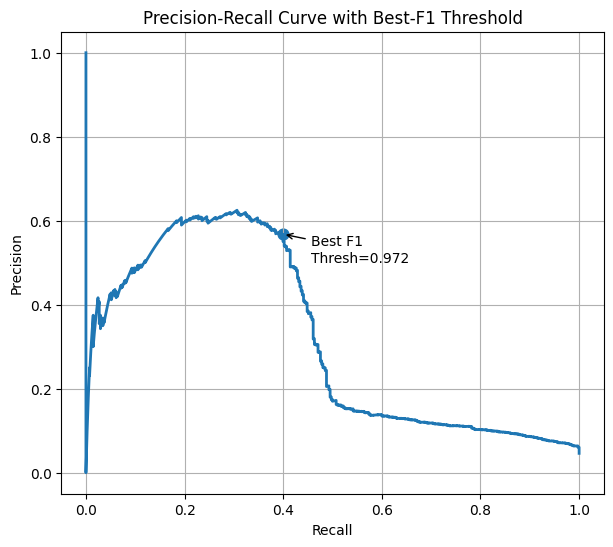

In [17]:
# ---------------------------------------
# Compute precision-recall curve
# ---------------------------------------
precision, recall, thresholds = precision_recall_curve(true, probs)

# thresholds has length N-1; precision/recall have length N
# We compute an F1 for each possible threshold
f1_scores = (2 * precision * recall) / (precision + recall + 1e-12)

# Best F1 occurs where f1_scores is max
best_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_idx]

# Convert curve index to threshold index:
# threshold index corresponds to precision[1:], recall[1:]
if best_idx == 0:
    best_threshold = 1.0   # extreme case
else:
    best_threshold = thresholds[best_idx - 1]

print("==========================================")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")
print("==========================================")

# ---------------------------------------
# Apply chosen threshold
# ---------------------------------------
best_preds = (probs >= best_threshold).astype(int)

print("\nClassification Report (Best Threshold):")
from sklearn.metrics import classification_report
print(classification_report(true, best_preds, target_names=["Licit","Illicit"]))

# ---------------------------------------
# Plot PR curve
# ---------------------------------------
plt.figure(figsize=(7,6))
plt.plot(recall, precision, linewidth=2)
plt.scatter(recall[best_idx], precision[best_idx], s=60)

plt.title("Precision-Recall Curve with Best-F1 Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")

# Annotate best point
plt.annotate(f"Best F1\nThresh={best_threshold:.3f}",
             (recall[best_idx], precision[best_idx]),
             textcoords="offset points",
             xytext=(20,-20),
             arrowprops=dict(arrowstyle="->"))

plt.grid(True)
plt.show()

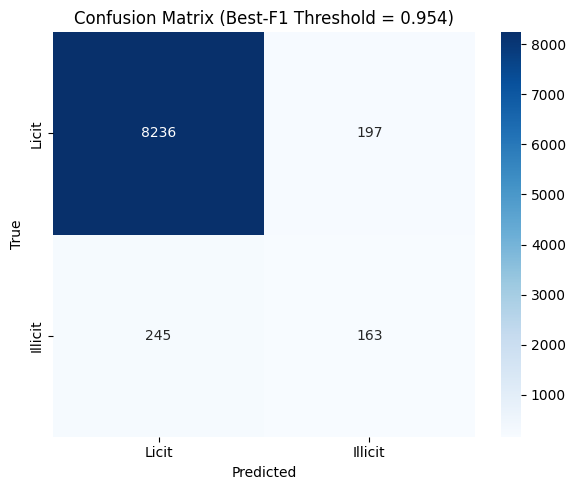

In [11]:
# compute confusion matrix
cm = confusion_matrix(true, best_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Licit", "Illicit"],
            yticklabels=["Licit", "Illicit"])

plt.title(f"Confusion Matrix (Best-F1 Threshold = {best_threshold:.3f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()